In [1]:
import pandas as pd
import pyodbc

In [2]:
sql_Conn = pyodbc.connect('DRIVER={SQL Server};SERVER=DS-Server;DATABASE=events_2023;Trusted_Connection=yes')

In [3]:
month = 1
year = 2023
dummy_df = pd.read_sql_query(f'SELECT Time,Action,ConditionName, Priority, Actor,AreaName FROM events_{month}_{year}', sql_Conn)
while month < 12:
    month += 1
    curr_df = pd.read_sql_query(f'SELECT Time,Action,ConditionName, Priority, Actor,AreaName FROM events_{month}_{year}', sql_Conn)
    dummy_df = pd.concat([dummy_df, curr_df], ignore_index=True)
    

print(dummy_df.shape)

(13793502, 6)


In [4]:
final_df_1.shape

(13793502, 6)

In [6]:
final_df_1.to_csv('final_df_1.csv')

NameError: name 'final_df_1' is not defined

In [7]:
init_df = dummy_df.copy()

In [8]:
init_df.sample(5)

,Time,Action,ConditionName,Priority,Actor,AreaName
11861712,2023-08-27 01:00:47.207,OK,OVRDI0,0.0,None,241_2_DCS
3149427,2023-03-26 12:14:14.303,OK,OFFNRM,0.0,None,331_0_DCS
10582096,2023-07-12 16:59:58.700,None,PVLOW,0.0,None,120
4690430,2023-04-01 20:19:31.900,None,CHANGE,0.0,None,GAS_350
5842947,2023-05-19 03:47:13.800,OK,PVLL,48.0,None,241_1_ESD


In [9]:
init_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13793502 entries, 0 to 13793501
Data columns (total 6 columns):
 #   Column         Dtype         
---  ------         -----         
 0   Time           datetime64[ns]
 1   Action         object        
 2   ConditionName  object        
 3   Priority       float64       
 4   Actor          object        
 5   AreaName       object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 631.4+ MB


In [10]:
df = init_df.copy()

In [11]:
df.head()

,Time,Action,ConditionName,Priority,Actor,AreaName
0,2023-01-24 21:07:05.013,None,OFFNRM,0.0,None,130
1,2023-01-24 21:07:05.013,None,OFFNRM,0.0,None,130
2,2023-01-24 21:07:05.013,None,OFFNRM,0.0,None,130
3,2023-01-24 21:07:05.013,None,OFFNRM,0.0,None,130
4,2023-01-24 21:07:05.013,None,OFFNRM,0.0,None,130


## Feature engineering with Time column

In [12]:
# Add to Time 5 hours (UTC+5)
from datetime import timedelta

df.loc[:,'Time'] = df['Time'] + timedelta(hours=5)
df.head()

,Time,Action,ConditionName,Priority,Actor,AreaName
0,2023-01-25 02:07:05.013,None,OFFNRM,0.0,None,130
1,2023-01-25 02:07:05.013,None,OFFNRM,0.0,None,130
2,2023-01-25 02:07:05.013,None,OFFNRM,0.0,None,130
3,2023-01-25 02:07:05.013,None,OFFNRM,0.0,None,130
4,2023-01-25 02:07:05.013,None,OFFNRM,0.0,None,130


## Merge Assets-Units dataframe

In [13]:
assets = pd.read_csv('Assets.csv', sep=';', encoding='cp1251')
assets.head()

,Asset,Unit
0,211,Unit_1
1,211_0_DCS,Unit_1
2,211_0_ESD,Unit_1
3,221,Unit_1
4,221_0_DCS,Unit_1


In [14]:
merged_df = df.merge(assets, left_on='AreaName', right_on='Asset', how='left').drop('Asset', axis=1)
merged_df.sample(5)

,Time,Action,ConditionName,Priority,Actor,AreaName,Unit
9745249,2023-07-30 13:44:54.900,None,ALARM,32.0,None,FIRE_830,NaN
1175445,2023-02-04 03:27:55.400,None,CHANGE,0.0,None,485_0_DCS,Unit_4
12640689,2023-09-09 15:47:03.300,None,CHANGE,0.0,None,GAS_350,Unit_1
6943021,2023-05-26 22:58:29.800,None,ALARM,0.0,None,110,GS
3462817,2023-03-08 09:30:30.600,ACK,ALARM,96.0,KANDYM\dtsoy,FIRE_110,GS


In [15]:
# count rows with unit and without
print(f'Without unit: {merged_df[merged_df.Unit.isna()].shape[0]}')
print(f'With unit: {merged_df[merged_df.Unit.notna()].shape[0]}')

Without unit: 1801884
With unit: 11996692


In [16]:
# Round time to halfhour, i.e. 11:15 - > 11 : 00 , 11:44 -> 11:30
df['Time'] = df['Time'].dt.floor(freq='10T')
df.head()

,Time,Action,ConditionName,Priority,Actor,AreaName
0,2023-01-25 02:00:00,None,OFFNRM,0.0,None,130
1,2023-01-25 02:00:00,None,OFFNRM,0.0,None,130
2,2023-01-25 02:00:00,None,OFFNRM,0.0,None,130
3,2023-01-25 02:00:00,None,OFFNRM,0.0,None,130
4,2023-01-25 02:00:00,None,OFFNRM,0.0,None,130


### Divide merged_df to Units

In [17]:
## unit 1 df
unit1_df = merged_df[merged_df['Unit'] == 'Unit_1']
unit1_df.shape[0]

1191293

In [18]:
## unit 2 df
unit2_df = merged_df[merged_df['Unit'] == 'Unit_2']
unit2_df.shape[0]

3132386

In [19]:
## unit 3 df
unit3_df = merged_df[merged_df['Unit'] == 'Unit_3']
unit3_df.shape[0]

1154053

In [20]:
## unit 4 df - TVS - HWS
unit4_df = merged_df[merged_df['Unit'] == 'Unit_4']
unit4_df.shape[0]

2339112

In [21]:
## unit 5 df - Gathering System
unit5_df = merged_df[merged_df['Unit'] == 'GS']
unit5_df.shape[0]

4179848

In [22]:
##system alarms
mask1 = merged_df['Actor'].isna() & merged_df['Action'].isna()
priorities = (16., 32., 48.)
mask2 =merged_df['Priority'].isin(priorities)
system_signs = ['DIAG', 'WARNING', 'REPLICATION', 'MANCOMPERROR', 'COMMS']
system_alarms = merged_df[merged_df['ConditionName'].isin(system_signs) & mask1 & mask2]
system_alarms.shape[0]

33565

## Work with Unit1

In [23]:
all_actions_1 = unit1_df[unit1_df['Actor'].notna()]
alarms_1 = unit1_df[unit1_df['Actor'].isna() & unit1_df['Action'].isna()]
print(f'Actions count: {all_actions_1.shape[0]}, Alarms count: {alarms_1.shape[0]}')

Actions count: 567231, Alarms count: 323802


### Divide action to acknowledges and actions (Changes)

In [24]:
acks_1 = all_actions_1[all_actions_1['Action'].fillna('No Action').str.contains('ACK')]
changes_1 = all_actions_1[all_actions_1['ConditionName'] == 'CHANGE']
print(f'Changes count: {changes_1.shape[0]}, Acknowldeges count: {acks_1.shape[0]}')
all_actions_1.sample(5)

Changes count: 437299, Acknowldeges count: 129141


,Time,Action,ConditionName,Priority,Actor,AreaName,Unit
5339500,2023-05-07 19:04:54.500,None,CHANGE,96.0,Мирзокулов Нурали Шавкатович,221_0_DCS,Unit_1
4703450,2023-04-27 09:57:11.500,None,CHANGE,96.0,Аллаев Абдурасул Халлокович,211_0_DCS,Unit_1
12531958,2023-09-20 17:35:08.100,None,CHANGE,96.0,Мирзокулов Нурали Шавкатович,221_0_DCS,Unit_1
2176828,2023-02-22 21:36:26.200,None,CHANGE,96.0,Саттаров Абдулазиз Аскарович,221_0_DCS,Unit_1
2177669,2023-02-22 23:22:06.700,None,CHANGE,96.0,Саттаров Абдулазиз Аскарович,221_0_DCS,Unit_1


### Delete not needed columns for Alarms and divide alarms

In [25]:
alarms_1 = alarms_1.drop(['Actor','Action', 'AreaName'], axis=1)

In [26]:
alarms_1.sample(5)

,Time,ConditionName,Priority,Unit
2022443,2023-02-17 03:00:27.560,PVLOW,32.0,Unit_1
5434671,2023-05-28 08:18:15.537,DISABL,0.0,Unit_1
12223751,2023-08-08 11:03:11.850,PVLOW,32.0,Unit_1
12793678,2023-09-23 14:00:14.653,PVHIGH,32.0,Unit_1
4533950,2023-04-28 04:15:07.560,BAD PV,32.0,Unit_1


### Divide alarms to priorities

In [27]:
## check alarms by priorities
alarms_1.Priority.value_counts()

32.0    165777
0.0     128132
48.0     26546
16.0      3162
96.0         1
Name: Priority, dtype: int64

In [28]:
# /** [Priority] 0 - JOURNAL, 15 - system, 16 - Low, 32 - HIGH, 48 - URGENT, 96 - OP **/
## divide alarms to only with journal and alarms with low, high and urgent priorities and system alarms
journal_alarms_1 = alarms_1[alarms_1['Priority'] == 0]
low_alarms_1 = alarms_1[alarms_1['Priority'] == 16]
high_alarms_1 = alarms_1[alarms_1['Priority'] == 32]
urgent_alarms_1 = alarms_1[alarms_1['Priority'] == 48]
print(f'Alarms count: {alarms_1.shape[0]},\n\
      Journal alarms count: {journal_alarms_1.shape[0]},\n\
      Low Priority alarms count: {low_alarms_1.shape[0]},\n\
      High Priority alarms count: {high_alarms_1.shape[0]},\n\
      Urgent Priority alarms count: {urgent_alarms_1.shape[0]},\n\
      ')

Alarms count: 323802,
      Journal alarms count: 128132,
      Low Priority alarms count: 3162,
      High Priority alarms count: 165777,
      Urgent Priority alarms count: 26546,
      


#### Extract BAD BP alarms

In [29]:
badpv_alarms_1 = alarms_1[alarms_1['ConditionName'] == 'BAD PV']
print(f'BAD PV alarms count: {badpv_alarms_1.shape[0]}')

BAD PV alarms count: 91664


#### Check consistensy of dfs

In [30]:
system_alarms.sample(5)

,Time,Action,ConditionName,Priority,Actor,AreaName,Unit
6054660,2023-05-19 11:08:39.000,None,COMMS,48.0,None,430,NaN
10996982,2023-08-21 14:30:36.900,None,COMMS,48.0,None,$SRV430SCS0011,NaN
5786367,2023-05-25 07:03:04.300,None,REPLICATION,16.0,None,$SRV430SRV0001,NaN
4796246,2023-04-23 09:34:51.000,None,COMMS,32.0,None,830,Unit_4
6140639,2023-05-31 06:38:46.500,None,COMMS,48.0,None,$SRV430SRV0001,NaN


In [31]:
journal_alarms_1.sample(5)

,Time,ConditionName,Priority,Unit
5036566,2023-05-20 16:38:16.000,CHANGE,0.0,Unit_1
799617,2023-01-03 01:58:21.260,DISABL,0.0,Unit_1
9527891,2023-07-07 03:24:43.680,DISABL,0.0,Unit_1
12607662,2023-09-07 16:13:49.050,DISABL,0.0,Unit_1
12660412,2023-09-24 14:20:54.200,CHANGE,0.0,Unit_1


In [32]:
low_alarms_1.sample(5)

,Time,ConditionName,Priority,Unit
9632706,2023-07-29 03:03:56.400,ALARM,16.0,Unit_1
4920174,2023-05-31 22:06:48.900,ALARM,16.0,Unit_1
764612,2023-01-09 16:53:33.400,ALARM,16.0,Unit_1
734311,2023-01-25 19:01:50.900,ALARM,16.0,Unit_1
5305220,2023-05-24 09:38:30.500,ALARM,16.0,Unit_1


In [33]:
high_alarms_1.sample(5)

,Time,ConditionName,Priority,Unit
5070711,2023-05-21 00:48:21.563,PVLOW,32.0,Unit_1
1077597,2023-01-16 00:12:31.697,PVLOW,32.0,Unit_1
12804621,2023-09-16 09:20:48.223,BAD PV,32.0,Unit_1
12754900,2023-09-22 00:18:20.240,PVHIGH,32.0,Unit_1
3049508,2023-03-16 04:16:37.813,BAD PV,32.0,Unit_1


In [34]:
urgent_alarms_1.sample(5)

,Time,ConditionName,Priority,Unit
12569296,2023-09-05 07:04:23.400,ALARM,48.0,Unit_1
3033899,2023-03-15 02:16:29.900,ALARM,48.0,Unit_1
5488186,2023-05-28 21:48:24.000,Control Failed,48.0,Unit_1
3209114,2023-03-04 16:25:45.780,PVLOLO,48.0,Unit_1
4913252,2023-05-31 15:52:08.050,OVRDSI,48.0,Unit_1


In [35]:
badpv_alarms_1.sample(5)

,Time,ConditionName,Priority,Unit
4613263,2023-04-03 23:43:37.910,BAD PV,32.0,Unit_1
3349832,2023-03-21 22:09:28.703,BAD PV,32.0,Unit_1
963912,2023-01-21 06:04:12.540,BAD PV,32.0,Unit_1
1045912,2023-01-23 01:33:03.273,BAD PV,32.0,Unit_1
4547903,2023-04-21 17:16:13.853,BAD PV,32.0,Unit_1


### Groupby alarm dfs by hour

In [36]:
journal_alarms_grouped_1 = journal_alarms_1.groupby('Time')['Unit'].agg('count').reset_index().rename(columns={'Unit': 'JournalAlarmCount'})
low_alarms_grouped_1 = low_alarms_1.groupby('Time')['Unit'].agg('count').reset_index().rename(columns={'Unit': 'LowAlarmCount'})
high_alarms_grouped_1 = high_alarms_1.groupby('Time')['Unit'].agg('count').reset_index().rename(columns={'Unit': 'HighAlarmCount'})
urgent_alarms_grouped_1 = urgent_alarms_1.groupby('Time')['Unit'].agg('count').reset_index().rename(columns={'Unit': 'UrgentAlarmCount'})
badpv_alarms_grouped_1 = badpv_alarms_1.groupby('Time')['Unit'].agg('count').reset_index().rename(columns={'Unit': 'BADPVCount'})
system_alarms_grouped = system_alarms.groupby('Time')['Unit'].agg('count').reset_index().rename(columns={'Unit': 'SystemAlarmCount'})
alarms_grouped_1 = alarms_1.groupby('Time')['Unit'].agg('count').reset_index().rename(columns={'Unit': 'AllAlarmCount'})

In [37]:
# create final alarm df
dummy_df_1 = journal_alarms_grouped_1.merge(low_alarms_grouped_1, how='left', on='Time')
dummy_df_1 = dummy_df_1.merge(high_alarms_grouped_1, how='left', on='Time')
dummy_df_1 = dummy_df_1.merge(urgent_alarms_grouped_1, how='left', on='Time')
dummy_df_1 = dummy_df_1.merge(badpv_alarms_grouped_1, how='left', on='Time')
dummy_df_1 = dummy_df_1.merge(system_alarms_grouped, how='left', on='Time')
dummy_df_1 = dummy_df_1.merge(alarms_grouped_1, how='left', on='Time')
alarm_count_1 = dummy_df_1.fillna(0).reset_index(drop=True)
alarm_count_1.sample(5)

,Time,JournalAlarmCount,LowAlarmCount,HighAlarmCount,UrgentAlarmCount,BADPVCount,SystemAlarmCount,AllAlarmCount
1360,2023-01-09 09:40:34.400,1,0.0,0.0,0.0,0.0,0.0,1
16700,2023-03-05 12:49:50.003,1,0.0,0.0,0.0,0.0,0.0,1
8130,2023-01-31 04:00:43.403,1,0.0,0.0,0.0,1.0,0.0,1
52083,2023-06-29 08:14:04.100,1,0.0,0.0,0.0,0.0,0.0,1
45076,2023-06-01 10:30:13.863,1,0.0,0.0,0.0,0.0,0.0,1


In [38]:
alarm_count_1[alarm_count_1.Time.dt.minute == 30]

,Time,JournalAlarmCount,LowAlarmCount,HighAlarmCount,UrgentAlarmCount,BADPVCount,SystemAlarmCount,AllAlarmCount
177,2023-01-02 14:30:04.620,1,0.0,0.0,0.0,0.0,0.0,1
654,2023-01-04 17:30:36.910,1,0.0,0.0,0.0,1.0,0.0,1
671,2023-01-04 18:30:44.490,1,0.0,0.0,0.0,0.0,0.0,1
809,2023-01-05 19:30:09.767,1,0.0,0.0,0.0,0.0,0.0,1
902,2023-01-06 12:30:34.300,1,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...
69240,2023-09-29 19:30:58.803,1,0.0,0.0,0.0,0.0,0.0,1
69338,2023-09-30 07:30:04.027,1,0.0,0.0,0.0,0.0,0.0,1
69359,2023-09-30 13:30:29.700,1,0.0,0.0,0.0,0.0,0.0,1
69360,2023-09-30 13:30:32.300,1,1.0,0.0,0.0,0.0,0.0,2


## Group changes and acks by 10 minute

In [39]:
acks_grouped_1 = acks_1.groupby('Time').size().reset_index().rename(columns={0: 'AcksCount'}).fillna(0)
acks_grouped_1.head(5)

,Time,AcksCount
0,2023-01-01 04:02:26.400,1
1,2023-01-01 04:04:43.500,1
2,2023-01-01 04:10:56.500,1
3,2023-01-01 04:12:09.600,1
4,2023-01-01 04:17:57.800,2


In [40]:
changes_grouped_1 = changes_1.groupby('Time').size().reset_index().rename(columns={0: 'ChangesCount'}).fillna(0)
changes_grouped_1.head(5)

,Time,ChangesCount
0,2023-01-01 03:59:42.200,1
1,2023-01-01 03:59:42.400,1
2,2023-01-01 03:59:42.600,1
3,2023-01-01 03:59:42.800,1
4,2023-01-01 03:59:43.500,1


## Calculate loading = 1*acks + 1*changes

In [41]:
loading_1 = changes_grouped_1.merge(acks_grouped_1, how='outer', on='Time').fillna(0)
WEIGHT_OF_ACKS = 1
loading_1['Loading'] = loading_1['ChangesCount'] + WEIGHT_OF_ACKS * loading_1['AcksCount']
loading_1 = loading_1.loc[:, ['Time', 'Loading']].reset_index(drop=True).fillna(0)
loading_1.head(5)

,Time,Loading
0,2023-01-01 03:59:42.200,1.0
1,2023-01-01 03:59:42.400,1.0
2,2023-01-01 03:59:42.600,1.0
3,2023-01-01 03:59:42.800,1.0
4,2023-01-01 03:59:43.500,1.0


## Drift loading 10 min backward 

In [42]:
from datetime import timedelta
loading = loading_1.copy().rename(columns={'Loading': 'AfterhhLoading'})
loading['Time'] = loading['Time'] - timedelta(minutes=10)
loading.head(5)

,Time,AfterhhLoading
0,2023-01-01 03:49:42.200,1.0
1,2023-01-01 03:49:42.400,1.0
2,2023-01-01 03:49:42.600,1.0
3,2023-01-01 03:49:42.800,1.0
4,2023-01-01 03:49:43.500,1.0


## Merge acks, changes and Loading

In [43]:
merged_acks_changes_1 = acks_grouped_1.merge(changes_grouped_1, how='outer', on='Time').reset_index(drop=True).fillna(0)
merged_loading = merged_acks_changes_1.merge(loading, how='right', on='Time').sort_values(by='Time').reset_index(drop=True).fillna(0)
merged_loading.head(5)

,Time,AcksCount,ChangesCount,AfterhhLoading
0,2023-01-01 03:49:42.200,0.0,0.0,1.0
1,2023-01-01 03:49:42.400,0.0,0.0,1.0
2,2023-01-01 03:49:42.600,0.0,0.0,1.0
3,2023-01-01 03:49:42.800,0.0,0.0,1.0
4,2023-01-01 03:49:43.500,0.0,0.0,1.0


In [44]:
alarm_count_1.head()

,Time,JournalAlarmCount,LowAlarmCount,HighAlarmCount,UrgentAlarmCount,BADPVCount,SystemAlarmCount,AllAlarmCount
0,2023-01-01 02:39:51.343,1,0.0,0.0,0.0,0.0,0.0,1
1,2023-01-01 02:39:59.093,1,0.0,0.0,0.0,0.0,0.0,1
2,2023-01-01 02:44:17.783,1,0.0,0.0,0.0,0.0,0.0,1
3,2023-01-01 02:44:30.833,1,0.0,0.0,0.0,0.0,0.0,1
4,2023-01-01 02:47:01.183,1,0.0,0.0,0.0,0.0,0.0,1


## Create final df for Unit1

In [45]:
final_df_1 = alarm_count_1.merge(merged_loading, how='right', on='Time').fillna(0).sort_values(by='Time')
final_df_1.head()

,Time,JournalAlarmCount,LowAlarmCount,HighAlarmCount,UrgentAlarmCount,BADPVCount,SystemAlarmCount,AllAlarmCount,AcksCount,ChangesCount,AfterhhLoading
0,2023-01-01 03:49:42.200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2023-01-01 03:49:42.400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2023-01-01 03:49:42.600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2023-01-01 03:49:42.800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2023-01-01 03:49:43.500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [46]:
final_df_1.to_csv('final_df_1.csv')

## Work with UnitGS

In [503]:
all_actions_2 = unit5_df[unit5_df['Actor'].notna()]
alarms_2 = unit5_df[unit5_df['Actor'].isna() & unit5_df['Action'].isna()]
print(f'Actions count: {all_actions_2.shape[0]}, Alarms count: {alarms_2.shape[0]}')

Actions count: 164326, Alarms count: 1672212


### Divide action to acknowledges and actions (Changes)

In [504]:
acks_2 = all_actions_2[all_actions_2['Action'].fillna('No Action').str.contains('ACK')]
changes_2 = all_actions_2[all_actions_2['ConditionName'] == 'CHANGE']
print(f'Changes count: {changes_2.shape[0]}, Acknowldeges count: {acks_2.shape[0]}')
all_actions_2.sample(5)

Changes count: 93158, Acknowldeges count: 68752


,Time,Action,ConditionName,Priority,Actor,AreaName,Unit
11259440,2023-08-06 08:30:00,None,CHANGE,96.0,KANDYM\tkhafizov,GAS_120,GS
3572729,2023-03-15 20:00:00,None,CHANGE,96.0,KANDYM\dtsoy,120,GS
2363617,2023-02-19 13:30:00,None,CHANGE,96.0,KANDYM\tkhafizov,GAS_130,GS
11178500,2023-08-28 11:00:00,ACK,ALARM,96.0,KANDYM\ATashniyazov,GAS_624,GS
3989332,2023-04-29 09:30:00,ACK PNT,ALARM,96.0,KANDYM\TKabilov,FIRE_110,GS


### Delete not needed columns for Alarms and divide alarms

In [505]:
alarms_2 = alarms_2.drop(['Actor','Action', 'AreaName'], axis=1)

In [506]:
alarms_2.sample(5)

,Time,ConditionName,Priority,Unit
7320885,2023-05-04 09:00:00,PVLOW,0.0,GS
6861262,2023-05-04 17:30:00,PVLOW,0.0,GS
13185539,2023-09-06 02:30:00,PVHIGH,0.0,GS
6909603,2023-05-15 08:00:00,PVHIGH,0.0,GS
11346404,2023-08-08 13:30:00,PVLOW,0.0,GS


### Divide alarms to priorities

In [507]:
## check alarms by priorities
alarms_2.Priority.value_counts()

0.0      1572164
32.0       48503
48.0       34785
16.0        8105
128.0       7399
47.0         693
Name: Priority, dtype: int64

In [508]:
# /** [Priority] 0 - JOURNAL, 15 - system, 16 - Low, 32 - HIGH, 48 - URGENT, 96 - OP **/
## divide alarms to only with journal and alarms with low, high and urgent priorities and system alarms
journal_alarms_2 = alarms_2[alarms_2['Priority'] == 0]
low_alarms_2 = alarms_2[alarms_2['Priority'] == 16]
high_alarms_2 = alarms_2[alarms_2['Priority'] == 32]
urgent_alarms_2 = alarms_2[alarms_2['Priority'] == 48]
print(f'Alarms count: {alarms_2.shape[0]},\n\
      Journal alarms count: {journal_alarms_2.shape[0]},\n\
      Low Priority alarms count: {low_alarms_2.shape[0]},\n\
      High Priority alarms count: {high_alarms_2.shape[0]},\n\
      Urgent Priority alarms count: {urgent_alarms_2.shape[0]},\n\
      ')

Alarms count: 1672212,
      Journal alarms count: 1572164,
      Low Priority alarms count: 8105,
      High Priority alarms count: 48503,
      Urgent Priority alarms count: 34785,
      


#### Extract BAD BP alarms

In [509]:
badpv_alarms_2 = alarms_2[alarms_2['ConditionName'] == 'BAD PV']
print(f'BAD PV alarms count: {badpv_alarms_2.shape[0]}')

BAD PV alarms count: 10344


#### Check consistensy of dfs

In [510]:
system_alarms.sample(5)

,Time,Action,ConditionName,Priority,Actor,AreaName,Unit
9181825,2023-06-10 11:00:00,None,COMMS,48.0,None,F&G,NaN
6790918,2023-05-23 09:30:00,None,COMMS,48.0,None,F&G_120,GS
7192940,2023-05-28 11:30:00,None,COMMS,32.0,None,610,GS
5292704,2023-05-23 16:00:00,None,COMMS,48.0,None,430,NaN
4553927,2023-04-17 12:00:00,None,COMMS,48.0,None,$SRV430SRV0002,NaN


In [511]:
journal_alarms_2.sample(5)

,Time,ConditionName,Priority,Unit
7030910,2023-05-13 21:00:00,PVHIGH,0.0,GS
6795561,2023-05-28 17:30:00,DISABL,0.0,GS
13227114,2023-09-13 16:00:00,PVHIGH,0.0,GS
7216630,2023-05-30 23:00:00,PVLOW,0.0,GS
6873855,2023-05-03 00:00:00,PVHIGH,0.0,GS


In [512]:
low_alarms_2.sample(5)

,Time,ConditionName,Priority,Unit
3465516,2023-03-23 10:30:00,ALARM,16.0,GS
10914973,2023-07-15 10:30:00,COMMS,16.0,GS
7256195,2023-05-16 10:30:00,ALARM,16.0,GS
2429258,2023-02-04 10:00:00,ALARM,16.0,GS
6751779,2023-05-06 10:30:00,OFFNRM,16.0,GS


In [513]:
high_alarms_2.sample(5)

,Time,ConditionName,Priority,Unit
6904711,2023-05-20 15:30:00,PVHI,32.0,GS
3445953,2023-03-17 13:30:00,PVHI,32.0,GS
7504617,2023-06-22 17:30:00,ALARM,32.0,GS
7955610,2023-06-10 15:30:00,PVLO,32.0,GS
13491887,2023-09-18 06:00:00,OFFNRM,32.0,GS


In [514]:
urgent_alarms_2.sample(5)

,Time,ConditionName,Priority,Unit
7540522,2023-06-05 22:00:00,ALARM,48.0,GS
3923207,2023-04-28 20:00:00,ALARM,48.0,GS
3574644,2023-03-13 14:00:00,PVHH,48.0,GS
8053931,2023-06-15 23:00:00,OFFNRM,48.0,GS
5106828,2023-05-04 15:00:00,PVHI,48.0,GS


In [515]:
badpv_alarms_2.sample(5)

,Time,ConditionName,Priority,Unit
93201,2023-01-10 21:00:00,BAD PV,32.0,GS
129562,2023-01-10 14:00:00,BAD PV,32.0,GS
11044975,2023-08-23 19:30:00,BAD PV,32.0,GS
7914004,2023-06-12 01:30:00,BAD PV,32.0,GS
7275015,2023-05-17 20:30:00,BAD PV,16.0,GS


### Groupby alarm dfs by halfhour

In [516]:
journal_alarms_grouped_2 = journal_alarms_2.groupby('Time')['Unit'].agg('count').reset_index().rename(columns={'Unit': 'JournalAlarmCount'})
low_alarms_grouped_2 = low_alarms_2.groupby('Time')['Unit'].agg('count').reset_index().rename(columns={'Unit': 'LowAlarmCount'})
high_alarms_grouped_2 = high_alarms_2.groupby('Time')['Unit'].agg('count').reset_index().rename(columns={'Unit': 'HighAlarmCount'})
urgent_alarms_grouped_2 = urgent_alarms_2.groupby('Time')['Unit'].agg('count').reset_index().rename(columns={'Unit': 'UrgentAlarmCount'})
badpv_alarms_grouped_2 = badpv_alarms_2.groupby('Time')['Unit'].agg('count').reset_index().rename(columns={'Unit': 'BADPVCount'})
alarms_grouped_2 = alarms_2.groupby('Time')['Unit'].agg('count').reset_index().rename(columns={'Unit': 'AllAlarmCount'})

In [517]:
# create final alarm df
dummy_df_2 = journal_alarms_grouped_2.merge(low_alarms_grouped_2, how='left', on='Time')
dummy_df_2 = dummy_df_2.merge(high_alarms_grouped_2, how='left', on='Time')
dummy_df_2 = dummy_df_2.merge(urgent_alarms_grouped_2, how='left', on='Time')
dummy_df_2 = dummy_df_2.merge(badpv_alarms_grouped_2, how='left', on='Time')
dummy_df_2 = dummy_df_2.merge(alarms_grouped_2, how='left', on='Time')
alarm_count_2 = dummy_df_2.fillna(0).reset_index(drop=True)
alarm_count_2.sample(5)

,Time,JournalAlarmCount,LowAlarmCount,HighAlarmCount,UrgentAlarmCount,BADPVCount,AllAlarmCount
7231,2023-06-26 01:00:00,63,0.0,0.0,1.0,0.0,64
6847,2023-06-18 01:00:00,140,0.0,1.0,0.0,0.0,144
6734,2023-06-15 16:30:00,143,5.0,7.0,1.0,0.0,157
5040,2023-05-11 09:30:00,182,0.0,10.0,26.0,0.0,218
8824,2023-07-29 05:30:00,105,0.0,1.0,0.0,0.0,106


## Group changes and acks by half hour

In [518]:
acks_grouped_2 = acks_2.groupby('Time').size().reset_index().rename(columns={0: 'AcksCount'}).fillna(0)
acks_grouped_2.head(5)

,Time,AcksCount
0,2023-01-01 00:00:00,2
1,2023-01-01 01:00:00,2
2,2023-01-01 02:30:00,1
3,2023-01-01 03:00:00,8
4,2023-01-01 06:00:00,5


In [519]:
changes_grouped_2 = changes_2.groupby('Time').size().reset_index().rename(columns={0: 'ChangesCount'}).fillna(0)
changes_grouped_2.head(5)

,Time,ChangesCount
0,2023-01-01 00:00:00,41
1,2023-01-01 01:00:00,5
2,2023-01-01 01:30:00,1
3,2023-01-01 05:00:00,20
4,2023-01-01 07:00:00,1


## Create final df for GS

In [520]:
merged_acks_changes_2 = acks_grouped_2.merge(changes_grouped_2, how='outer', on='Time').reset_index(drop=True).fillna(0)
final_df_2 = alarm_count_1.merge(merged_acks_changes_2, how='outer', on='Time').fillna(0).sort_values(by='Time')
final_df_2.head()

,Time,JournalAlarmCount,LowAlarmCount,HighAlarmCount,UrgentAlarmCount,BADPVCount,SystemAlarmCount,AllAlarmCount,AcksCount,ChangesCount
7333,2023-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,41.0
7334,2023-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0
9666,2023-01-01 01:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
0,2023-01-01 02:30:00,11.0,0.0,0.0,0.0,0.0,0.0,11.0,1.0,0.0
1,2023-01-01 03:00:00,2.0,0.0,0.0,0.0,0.0,0.0,2.0,8.0,0.0


In [521]:
merged_final_df = final_df_1.merge(final_df_2, how='left', on='Time', suffixes = ('_1', '_GS')).fillna(0).sort_values(by='Time')
print(merged_final_df.shape)
merged_final_df.head()

(12404, 20)


,Time,JournalAlarmCount_1,LowAlarmCount_1,HighAlarmCount_1,UrgentAlarmCount_1,BADPVCount_1,SystemAlarmCount_1,AllAlarmCount_1,AcksCount_1,ChangesCount_1,AfterhhLoading,JournalAlarmCount_GS,LowAlarmCount_GS,HighAlarmCount_GS,UrgentAlarmCount_GS,BADPVCount_GS,SystemAlarmCount_GS,AllAlarmCount_GS,AcksCount_GS,ChangesCount_GS
0,2023-01-01 03:00:00,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,8.0,0.0
1,2023-01-01 03:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,14.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-01-01 04:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023-01-01 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,74.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0


## Work with Unit3

In [420]:
all_actions_2 = unit2_df[unit2_df['Actor'].notna()]
alarms_2 = unit2_df[unit2_df['Actor'].isna() & unit2_df['Action'].isna()]
print(f'Actions count: {all_actions_2.shape[0]}, Alarms count: {alarms_2.shape[0]}')

Actions count: 595301, Alarms count: 1174930


### Divide action to acknowledges and actions (Changes)

In [421]:
acks_2 = all_actions_2[all_actions_2['Action'].fillna('No Action').str.contains('ACK')]
changes_2 = all_actions_2[all_actions_2['ConditionName'] == 'CHANGE']
print(f'Changes count: {changes_2.shape[0]}, Acknowldeges count: {acks_2.shape[0]}')
all_actions_2.sample(5)

Changes count: 342618, Acknowldeges count: 247227


,Time,Action,ConditionName,Priority,Actor,AreaName,Unit
9965212,2023-07-20 11:00:00,None,CHANGE,96.0,Денис Шеин,243_2_DCS,Unit_2
12982887,2023-09-30 07:00:00,None,CHANGE,96.0,Чебыкин Пётр Сергеевич,353_1_DCS,Unit_2
8359745,2023-06-20 00:00:00,None,CHANGE,96.0,Соколов Константин Викторович,241_1_DCS,Unit_2
5585787,2023-05-01 04:00:00,None,CHANGE,96.0,Соколов Константин Викторович,GAS_241,Unit_2
1303298,2023-02-15 02:30:00,None,CHANGE,96.0,Чебыкин Пётр Сергеевич,247_1_DCS,Unit_2


### Delete not needed columns for Alarms and divide alarms

In [422]:
alarms_2 = alarms_2.drop(['Actor','Action', 'AreaName'], axis=1)

In [423]:
alarms_2.sample(5)

,Time,ConditionName,Priority,Unit
8497517,2023-06-25 09:00:00,OFFNRM,0.0,Unit_2
10210960,2023-07-30 10:00:00,DISABL,0.0,Unit_2
6597907,2023-05-07 08:30:00,OFFNRM,0.0,Unit_2
12936513,2023-09-23 00:00:00,OFFNRM,0.0,Unit_2
5769648,2023-05-24 16:00:00,DISABL,0.0,Unit_2


### Divide alarms to priorities

In [424]:
## check alarms by priorities
alarms_2.Priority.value_counts()

0.0      772950
32.0     222084
48.0     159575
128.0     16095
16.0       4137
Name: Priority, dtype: int64

In [425]:
# /** [Priority] 0 - JOURNAL, 15 - system, 16 - Low, 32 - HIGH, 48 - URGENT, 96 - OP **/
## divide alarms to only with journal and alarms with low, high and urgent priorities and system alarms
journal_alarms_2 = alarms_2[alarms_2['Priority'] == 0]
low_alarms_2 = alarms_2[alarms_2['Priority'] == 16]
high_alarms_2 = alarms_2[alarms_2['Priority'] == 32]
urgent_alarms_2 = alarms_2[alarms_2['Priority'] == 48]
print(f'Alarms count: {alarms_2.shape[0]},\n\
      Journal alarms count: {journal_alarms_2.shape[0]},\n\
      Low Priority alarms count: {low_alarms_2.shape[0]},\n\
      High Priority alarms count: {high_alarms_2.shape[0]},\n\
      Urgent Priority alarms count: {urgent_alarms_2.shape[0]},\n\
      ')

Alarms count: 1174930,
      Journal alarms count: 772950,
      Low Priority alarms count: 4137,
      High Priority alarms count: 222084,
      Urgent Priority alarms count: 159575,
      


#### Extract BAD BP alarms

In [426]:
badpv_alarms_2 = alarms_2[alarms_2['ConditionName'] == 'BAD PV']
print(f'BAD PV alarms count: {badpv_alarms_2.shape[0]}')

BAD PV alarms count: 47199


#### Check consistensy of dfs

In [427]:
system_alarms.sample(5)

,Time,Action,ConditionName,Priority,Actor,AreaName,Unit
322706,2023-01-17 16:30:00,None,REPLICATION,16.0,None,$SRV430SRV0001,NaN
6147569,2023-05-30 18:00:00,None,COMMS,32.0,None,410,Unit_3
4749465,2023-04-25 21:00:00,None,REPLICATION,16.0,None,$SRV430SRV0002,NaN
3460569,2023-03-11 11:30:00,None,COMMS,32.0,None,610,GS
4475558,2023-04-21 22:30:00,None,REPLICATION,16.0,None,$SRV430SRV0002,NaN


In [428]:
journal_alarms_2.sample(5)

,Time,ConditionName,Priority,Unit
273103,2023-01-23 19:00:00,DISABL,0.0,Unit_2
11805670,2023-08-11 04:00:00,OFFNRM,0.0,Unit_2
11793411,2023-08-02 18:00:00,OVRDI0,0.0,Unit_2
369777,2023-01-22 14:00:00,OVRDI0,0.0,Unit_2
8347840,2023-06-27 22:30:00,OVRDI0,0.0,Unit_2


In [429]:
low_alarms_2.sample(5)

,Time,ConditionName,Priority,Unit
6649019,2023-05-31 04:00:00,ALARM,16.0,Unit_2
4329505,2023-04-01 04:30:00,ALARM,16.0,Unit_2
6106403,2023-05-23 07:00:00,ALARM,16.0,Unit_2
6034318,2023-05-23 14:30:00,ALARM,16.0,Unit_2
6005174,2023-05-24 15:00:00,ALARM,16.0,Unit_2


In [430]:
high_alarms_2.sample(5)

,Time,ConditionName,Priority,Unit
451666,2023-01-13 10:00:00,BAD PV,32.0,Unit_2
8593861,2023-06-10 06:30:00,BAD PV,32.0,Unit_2
8569774,2023-06-11 17:00:00,PVHIGH,32.0,Unit_2
5764337,2023-05-24 11:00:00,PVHIGH,32.0,Unit_2
13142774,2023-09-21 23:30:00,PVHI,32.0,Unit_2


In [431]:
urgent_alarms_2.sample(5)

,Time,ConditionName,Priority,Unit
5822877,2023-05-27 04:30:00,ALARM,48.0,Unit_2
5755161,2023-05-23 11:00:00,ALARM,48.0,Unit_2
5914628,2023-05-21 10:00:00,ALARM,48.0,Unit_2
5736265,2023-05-21 12:30:00,ALARM,48.0,Unit_2
11646453,2023-08-28 19:30:00,ALARM,48.0,Unit_2


In [432]:
badpv_alarms_2.sample(5)

,Time,ConditionName,Priority,Unit
2757819,2023-03-02 17:30:00,BAD PV,32.0,Unit_2
10101925,2023-07-21 09:30:00,BAD PV,32.0,Unit_2
11716918,2023-08-16 03:00:00,BAD PV,32.0,Unit_2
8272150,2023-06-09 05:30:00,BAD PV,32.0,Unit_2
424588,2023-01-11 18:00:00,BAD PV,32.0,Unit_2


### Groupby alarm dfs by halfhour

In [433]:
journal_alarms_grouped_2 = journal_alarms_2.groupby('Time')['Unit'].agg('count').reset_index().rename(columns={'Unit': 'JournalAlarmCount'})
low_alarms_grouped_2 = low_alarms_2.groupby('Time')['Unit'].agg('count').reset_index().rename(columns={'Unit': 'LowAlarmCount'})
high_alarms_grouped_2 = high_alarms_2.groupby('Time')['Unit'].agg('count').reset_index().rename(columns={'Unit': 'HighAlarmCount'})
urgent_alarms_grouped_2 = urgent_alarms_2.groupby('Time')['Unit'].agg('count').reset_index().rename(columns={'Unit': 'UrgentAlarmCount'})
badpv_alarms_grouped_2 = badpv_alarms_2.groupby('Time')['Unit'].agg('count').reset_index().rename(columns={'Unit': 'BADPVCount'})
alarms_grouped_2 = alarms_2.groupby('Time')['Unit'].agg('count').reset_index().rename(columns={'Unit': 'AllAlarmCount'})

In [434]:
# create final alarm df
dummy_df_2 = journal_alarms_grouped_2.merge(low_alarms_grouped_2, how='left', on='Time')
dummy_df_2 = dummy_df_2.merge(high_alarms_grouped_2, how='left', on='Time')
dummy_df_2 = dummy_df_2.merge(urgent_alarms_grouped_2, how='left', on='Time')
dummy_df_2 = dummy_df_2.merge(badpv_alarms_grouped_2, how='left', on='Time')
dummy_df_2 = dummy_df_2.merge(alarms_grouped_2, how='left', on='Time')
alarm_count_2 = dummy_df_2.fillna(0).reset_index(drop=True)
alarm_count_2.sample(5)

,Time,JournalAlarmCount,LowAlarmCount,HighAlarmCount,UrgentAlarmCount,BADPVCount,AllAlarmCount
12464,2023-09-22 11:00:00,52,0.0,21.0,19.0,5.0,95
6646,2023-05-20 15:00:00,182,4.0,30.0,220.0,7.0,436
6318,2023-05-13 15:30:00,41,0.0,2.0,0.0,1.0,44
2819,2023-03-01 02:00:00,21,0.0,1.0,2.0,1.0,25
1159,2023-01-25 06:30:00,46,0.0,11.0,5.0,4.0,63


## Group changes and acks by half hour

In [435]:
acks_grouped_2 = acks_2.groupby('Time').size().reset_index().rename(columns={0: 'AcksCount'}).fillna(0)
acks_grouped_2.head(5)

,Time,AcksCount
0,2023-01-01 00:00:00,34
1,2023-01-01 00:30:00,6
2,2023-01-01 01:00:00,2
3,2023-01-01 01:30:00,7
4,2023-01-01 02:00:00,40


In [436]:
changes_grouped_2 = changes_2.groupby('Time').size().reset_index().rename(columns={0: 'ChangesCount'}).fillna(0)
changes_grouped_2.head(5)

,Time,ChangesCount
0,2023-01-01 00:00:00,14
1,2023-01-01 00:30:00,3
2,2023-01-01 01:00:00,24
3,2023-01-01 01:30:00,1
4,2023-01-01 02:00:00,6


## Create final df for Unit2

In [438]:
merged_acks_changes_2 = acks_grouped_2.merge(changes_grouped_2, how='outer', on='Time').reset_index(drop=True).fillna(0)
final_df_2 = alarm_count_1.merge(merged_acks_changes_2, how='outer', on='Time').fillna(0).sort_values(by='Time')
final_df_2.head()

,Time,JournalAlarmCount,LowAlarmCount,HighAlarmCount,UrgentAlarmCount,BADPVCount,SystemAlarmCount,AllAlarmCount,AcksCount,ChangesCount
7333,2023-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,14.0
7334,2023-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,3.0
7335,2023-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,24.0
7336,2023-01-01 01:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0
7337,2023-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,6.0


In [443]:
merged_final_df = final_df_1.merge(final_df_2, how='outer', on='Time', suffixes = ('_1', '_2')).fillna(0).sort_values(by='Time')
merged_final_df.head()

,Time,JournalAlarmCount_1,LowAlarmCount_1,HighAlarmCount_1,UrgentAlarmCount_1,BADPVCount_1,SystemAlarmCount_1,AllAlarmCount_1,AcksCount_1,ChangesCount_1,AfterhhLoading,JournalAlarmCount_2,LowAlarmCount_2,HighAlarmCount_2,UrgentAlarmCount_2,BADPVCount_2,SystemAlarmCount_2,AllAlarmCount_2,AcksCount_2,ChangesCount_2
12446,2023-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,14.0
12447,2023-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,3.0
12448,2023-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,24.0
12449,2023-01-01 01:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0
12450,2023-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,6.0


## Add month and hour feature

In [305]:
final_df['Month'] = final_df['Time'].dt.month
final_df['Hour'] = final_df['Time'].dt.hour

In [306]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Visual analize

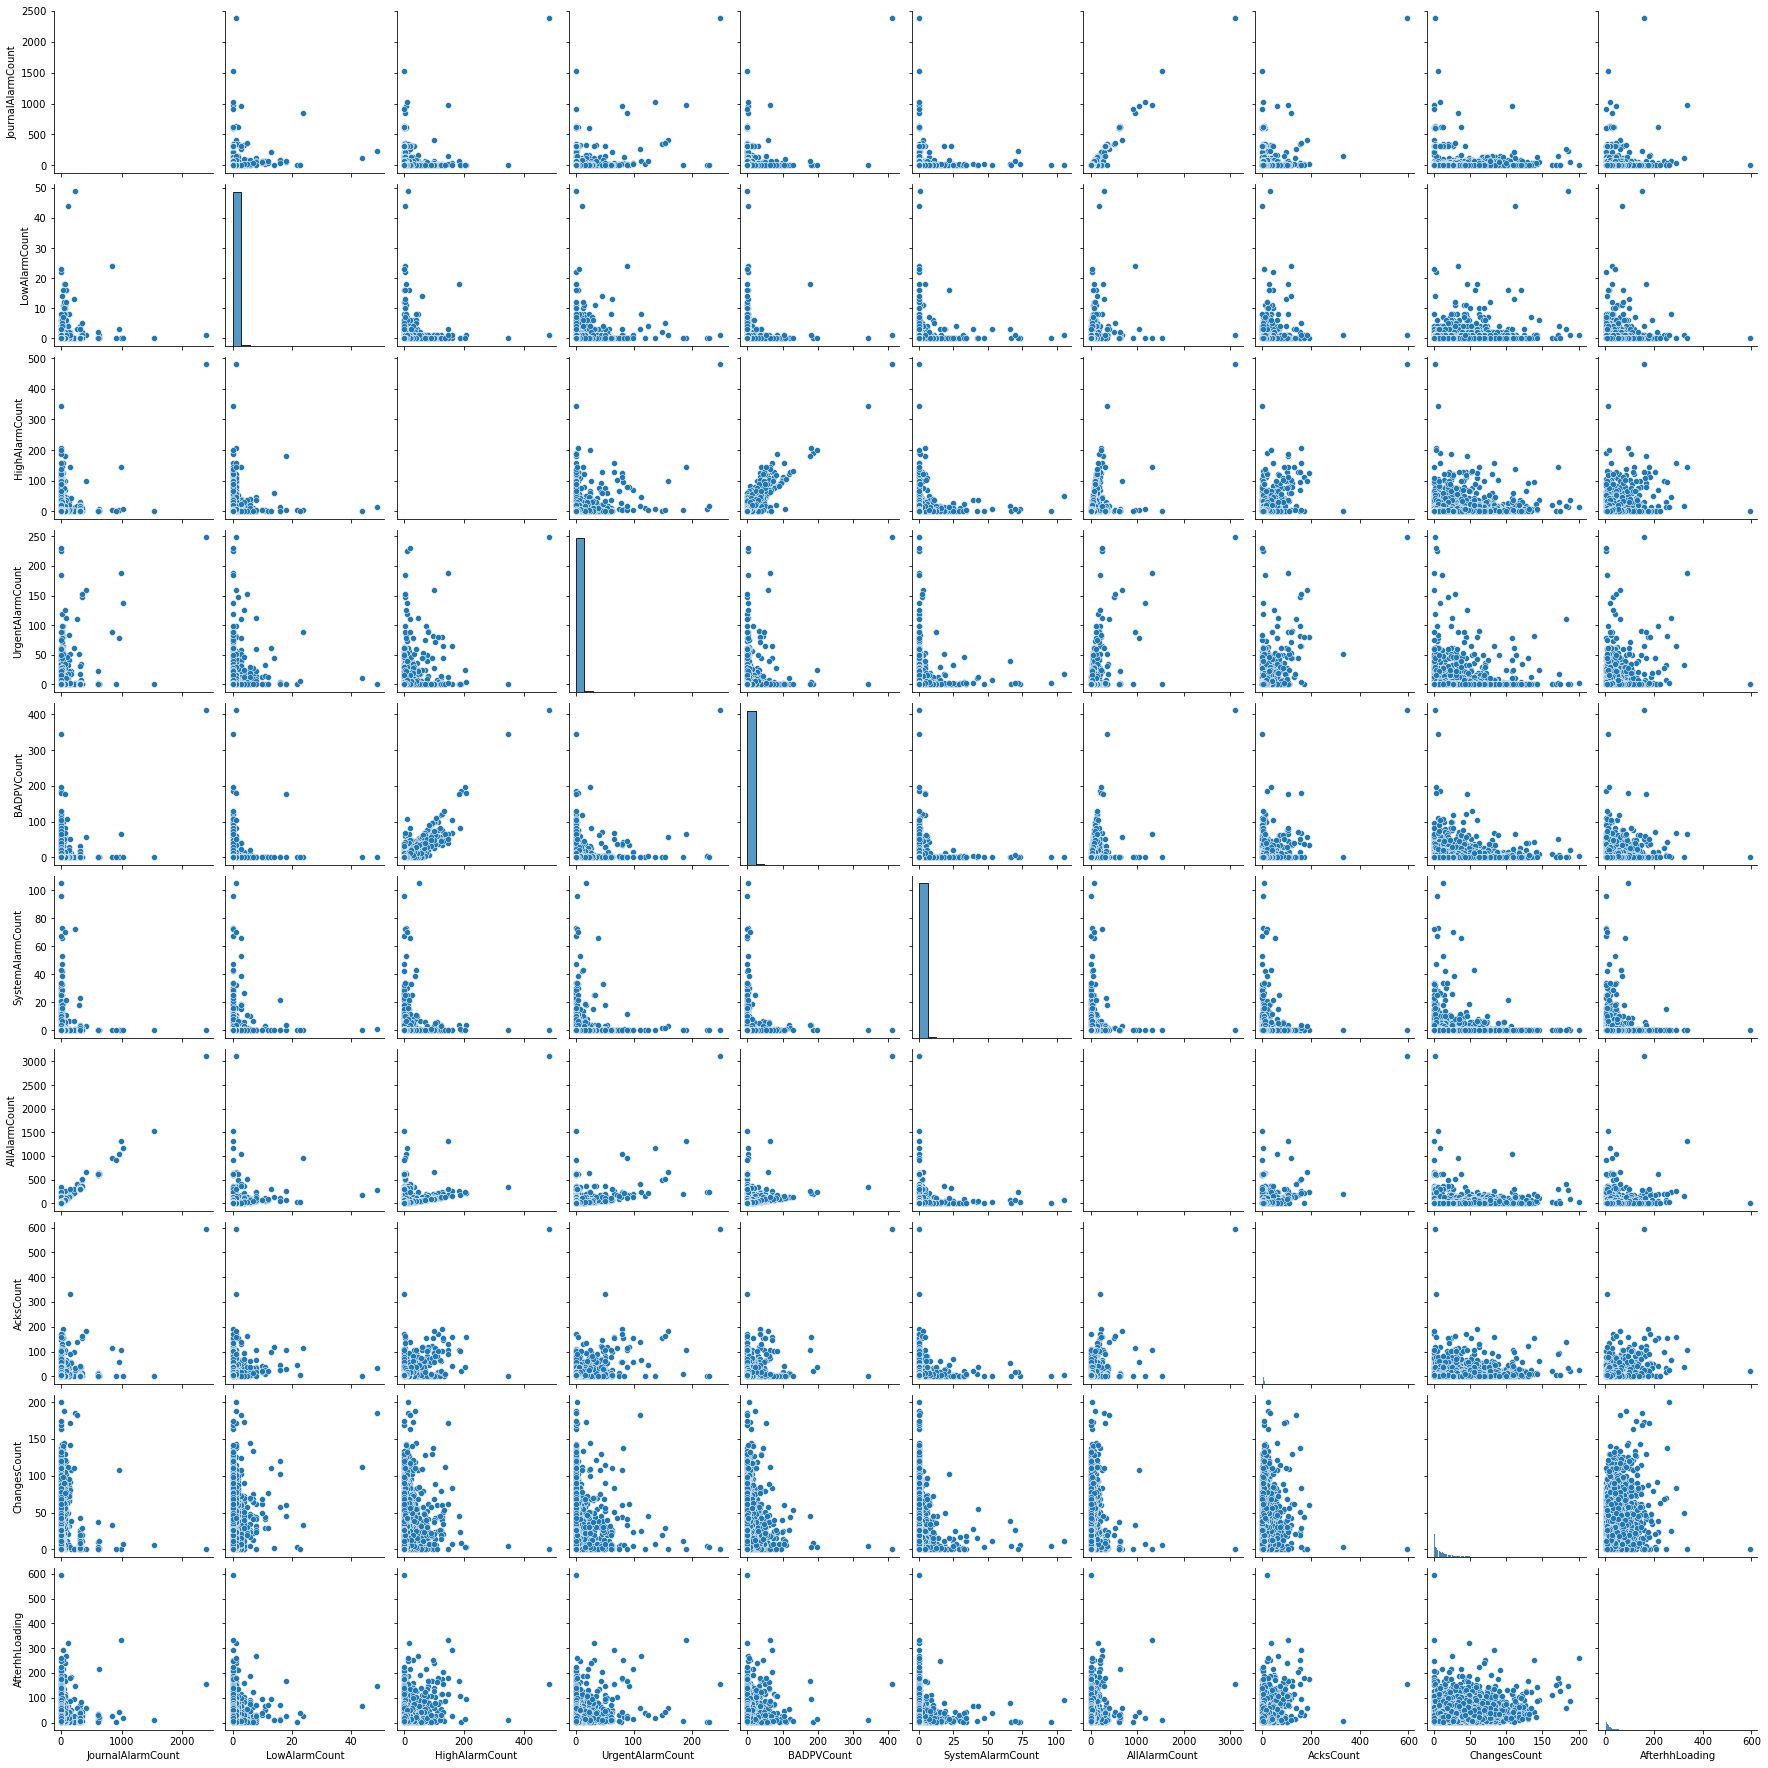

In [848]:
visual_df = final_df_1
sns.pairplot(visual_df)

In [124]:
visual_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12446 entries, 0 to 12445
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Time               12446 non-null  datetime64[ns]
 1   JournalAlarmCount  12446 non-null  float64       
 2   LowAlarmCount      12446 non-null  float64       
 3   HighAlarmCount     12446 non-null  float64       
 4   UrgentAlarmCount   12446 non-null  float64       
 5   BADPVCount         12446 non-null  float64       
 6   SystemAlarmCount   12446 non-null  float64       
 7   AllAlarmCount      12446 non-null  float64       
 8   AcksCount          12446 non-null  float64       
 9   ChangesCount       12446 non-null  float64       
 10  AfterhhLoading     12446 non-null  float64       
 11  Month              12446 non-null  int64         
 12  Hour               12446 non-null  int64         
dtypes: datetime64[ns](1), float64(10), int64(2)
memory usage: 1.3

In [307]:
visual_df.describe().round(2)

,JournalAlarmCount,LowAlarmCount,HighAlarmCount,UrgentAlarmCount,BADPVCount,SystemAlarmCount,AllAlarmCount,AcksCount,ChangesCount,AfterhhLoading,Month,Hour
count,12446.00,12446.00,12446.00,12446.00,12446.00,12446.00,12446.00,12446.00,12446.00,12446.00,12446.00,12446.00
mean,10.30,0.24,9.26,1.76,5.22,0.56,21.56,10.38,35.14,45.51,5.02,11.51
std,61.34,1.36,23.14,12.23,17.98,3.81,74.23,19.08,35.34,44.46,2.55,6.92
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,11.00,17.00,3.00,6.00
50%,1.00,0.00,2.00,0.00,0.00,0.00,6.00,6.00,25.00,33.00,5.00,11.50
75%,4.00,0.00,9.00,0.00,1.00,0.00,20.75,12.00,47.00,60.00,7.00,17.00
max,2483.00,73.00,516.00,641.00,431.00,163.00,3219.00,655.00,434.00,703.00,9.00,23.00


In [126]:
def outliers_iqr_mod(data, feature, left=1.5, right=1.5):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr*left)
    upper_bound = quartile_3 + (iqr*right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [127]:
outliers, cleaned = outliers_iqr_mod(visual_df, 'AfterhhLoading', left=3, right=0.7)
print(f'Count of outliers: {outliers.shape[0]}')
print(f'Count of cleaned: {cleaned.shape[0]}')

Count of outliers: 1524
Count of cleaned: 10922


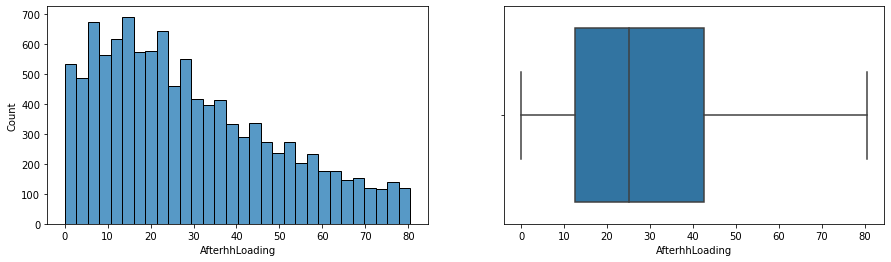

In [128]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
histplot = sns.histplot(data=cleaned, x='AfterhhLoading', ax=axes[0]);
boxplot = sns.boxplot(data=cleaned, x='AfterhhLoading', ax=axes[1]);

Text(0.5, 1.0, 'Logged After half hour distribution')

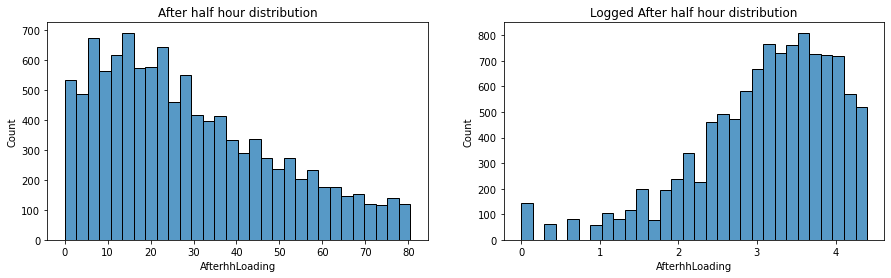

In [129]:
## Histpltot for logged values
fig, axes = plt.subplots(1,2, figsize=(15,4))
# Histogram for init feature
histplot = sns.histplot(cleaned['AfterhhLoading'], bins=30, ax=axes[0]);
histplot.set_title('After half hour distribution')

# Histogram for logged feature
log_loading = np.log(cleaned['AfterhhLoading'] + 1)
histplot = sns.histplot(log_loading, bins=30, ax=axes[1]);
histplot.set_title('Logged After half hour distribution')

In [130]:
cleaned['AfterhhLoading'].skew()

0.6550135520726145

In [131]:
log_loading.skew()

-1.0446187801773201

In [132]:
## outlier Z score

def outliers_z_score_mod(data, feature, log_scale=False, left=3, right=3):
    if log_scale:
        x = np.log(data[feature] + 1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [133]:
outliers, cleaned = outliers_z_score_mod(final_df, 'AfterhhLoading', right=4, left=4, log_scale=False)
print(f'Count of outliers: {outliers.shape[0]}')
print(f'Count of cleaned: {cleaned.shape[0]}')

Count of outliers: 81
Count of cleaned: 12365


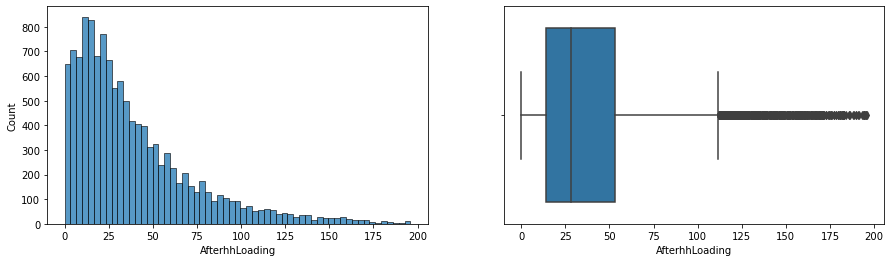

In [134]:
# Histogram for feature after z score
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
histplot = sns.histplot(data=cleaned, x='AfterhhLoading', ax=axes[0]);
boxplot = sns.boxplot(data=cleaned, x='AfterhhLoading', ax=axes[1]);

In [135]:
exclude_cols = ['Time', 'AfterhhLoading' ]
for col in cleaned.columns:
    if col not in exclude_cols:
        coef = round(np.corrcoef(cleaned[col].values, cleaned['AfterhhLoading'].values)[0, 1],2)
        print(f'Correlation coefficient for column {col}: {coef}')

Correlation coefficient for column JournalAlarmCount: 0.03
Correlation coefficient for column LowAlarmCount: 0.07
Correlation coefficient for column HighAlarmCount: 0.13
Correlation coefficient for column UrgentAlarmCount: 0.06
Correlation coefficient for column BADPVCount: 0.07
Correlation coefficient for column SystemAlarmCount: 0.01
Correlation coefficient for column AllAlarmCount: 0.07
Correlation coefficient for column AcksCount: 0.2
Correlation coefficient for column ChangesCount: 0.41
Correlation coefficient for column Month: -0.01
Correlation coefficient for column Hour: -0.03


In [117]:
outliers, cleaned = outliers_z_score_mod(cleaned, 'HighAlarmCount', right=2, left=2, log_scale=False)
print(f'Count of outliers: {outliers.shape[0]}')
print(f'Count of cleaned: {cleaned.shape[0]}')

Count of outliers: 334
Count of cleaned: 12031


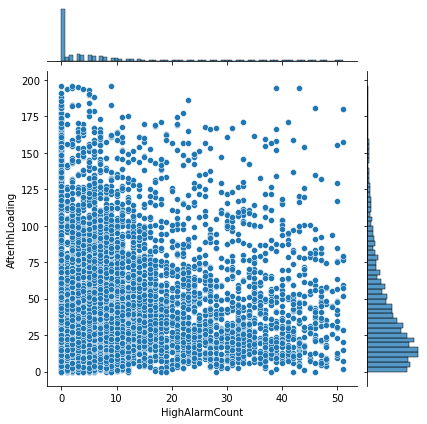

In [118]:
sns.jointplot(
    data = cleaned,
    x='HighAlarmCount',
    y='AfterhhLoading',
    );

In [119]:
final_df.to_csv('unit1_2023_df.csv')

In [137]:
pivot = final_df.pivot_table(
    values='AfterhhLoading',
    columns='Time',
    index='Month',)
pivot

Time,2023-01-01 02:30:00,2023-01-01 03:00:00,2023-01-01 03:30:00,2023-01-01 04:00:00,2023-01-01 04:30:00,2023-01-01 05:00:00,2023-01-01 05:30:00,2023-01-01 06:00:00,2023-01-01 06:30:00,2023-01-01 07:00:00,...,2023-09-30 19:00:00,2023-09-30 19:30:00,2023-09-30 20:00:00,2023-09-30 20:30:00,2023-09-30 21:00:00,2023-09-30 21:30:00,2023-09-30 22:00:00,2023-09-30 22:30:00,2023-09-30 23:00:00,2023-09-30 23:30:00
Month,,,,,,,,,,,,,,,,,,,,,
1,0.0,5.0,19.0,2.0,75.5,30.5,96.0,20.0,60.5,30.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,47.5,29.0,51.0,60.0,127.0,57.5,66.0,15.0,22.5,0.0


<AxesSubplot:xlabel='Time', ylabel='Month'>

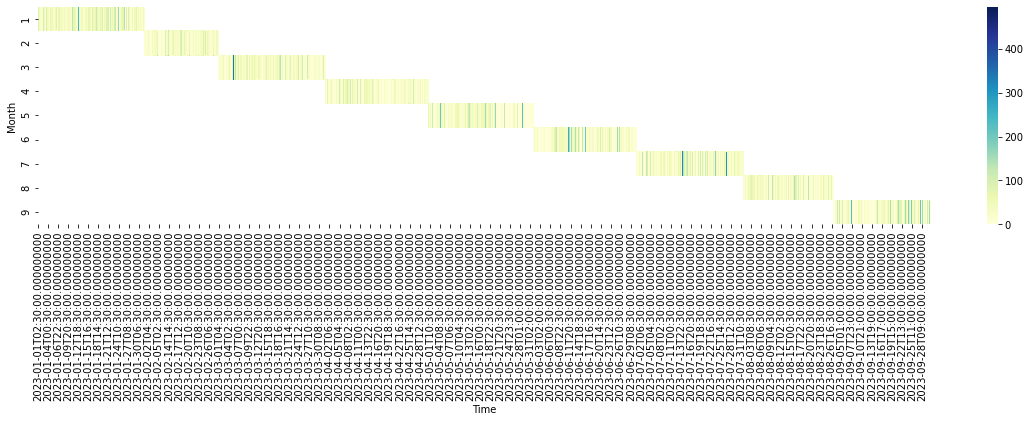

In [139]:
fig = plt.figure(figsize=(20,4))
sns.heatmap(data= pivot, cmap='YlGnBu')

## Обучаем и проверяем

In [791]:
test_df = final_df_1.copy()
y = test_df['AfterhhLoading']
X = test_df(['AfterhhLoading', 'Time'], axis=1)

In [792]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [793]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [794]:
X_train.shape

(24075, 9)

In [795]:
X_test.shape

(10318, 9)

## RandomForest

In [796]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [797]:
predict_test_rf = rf.predict(X_test)

In [798]:
r2_score(y_test, predict_test_rf)

0.11282540760247983

In [724]:
predict_test_rf

array([116.57      ,  48.37333333, 103.03      , ...,  46.17238095,
        75.16      ,  83.13      ])

In [725]:
y_test

4438     48.0
3189     11.0
1114     78.0
6105     60.0
4146     15.0
        ...  
4767     88.0
2112      8.0
2653     31.0
4401    217.0
3696     55.0
Name: AfterhhLoading, Length: 1860, dtype: float64

## GradientBoostingRegressor

In [799]:
from sklearn.ensemble import GradientBoostingRegressor

In [800]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

GradientBoostingRegressor()

In [801]:
predict_test_gdr = gbr.predict(X_test)

In [802]:
r2_score(y_test, predict_test_gdr)

0.2023528828695288

In [803]:
predict_test_gdr

array([37.4490987 , 15.0227073 ,  9.40982482, ..., 10.28836736,
        9.40982482, 10.14242461])

In [804]:
y_test

26007    18.0
33417     4.0
11066     9.0
5697      8.0
3121     34.0
         ... 
9638     28.0
20688    37.0
5866     18.0
8489     12.0
13913     3.0
Name: AfterhhLoading, Length: 10318, dtype: float64

### LinearRegression

In [805]:
from sklearn.linear_model import LinearRegression

In [818]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [819]:
X_train.shape

(24075, 9)

In [820]:
X_test.shape

(10318, 9)

In [821]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [822]:
predict_test_lr = lr.predict(X_test)

In [823]:
r2_score(y_test, predict_test_lr)

0.22753253978508614

In [824]:
predict_test_lr

array([11.71113836, 21.55955155, 22.44964264, ..., 11.23077016,
       12.03695308, 16.99022952])

In [825]:
y_test

19214     6.0
22806    20.0
12423     9.0
32515     2.0
34275    59.0
         ... 
24006     5.0
28818    10.0
19424    19.0
30737     4.0
31845    13.0
Name: AfterhhLoading, Length: 10318, dtype: float64

In [ ]:
## Bad scores. Need to refactor table

## Creature feature LoadingScore 

In [826]:
final_df = final_df_1.copy()

In [827]:
loading_25 = final_df['AfterhhLoading'].quantile(0.25)
loading_50 = final_df['AfterhhLoading'].quantile(0.50)
loading_75 = final_df['AfterhhLoading'].quantile(0.75)
print(f'Loading 25 quantile: {loading_25}, Loading 50 quantile: {loading_50}, Loading 75 quantile: {loading_75}')

Loading 25 quantile: 5.0, Loading 50 quantile: 10.0, Loading 75 quantile: 21.0


In [828]:
def get_loading_score(value):
    if value < loading_25:
        return 1
    elif value < loading_50: 
        return 2
    elif value < loading_75:
        return 3
    else:
        return 4

In [830]:
final_df.head()

,Time,JournalAlarmCount,LowAlarmCount,HighAlarmCount,UrgentAlarmCount,BADPVCount,SystemAlarmCount,AllAlarmCount,AcksCount,ChangesCount,AfterhhLoading
0,2023-01-01 03:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
1,2023-01-01 03:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
2,2023-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,5.0
3,2023-01-01 04:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,14.0
4,2023-01-01 04:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [834]:
final_df['LoadingScore'] = final_df_1['AfterhhLoading'].apply(get_loading_score)
final_df['LoadingScore'].head()

0    2
1    2
2    2
3    3
4    1
Name: LoadingScore, dtype: int64

## Check regression with new target feature

## RandomForest

In [835]:
y = final_df['LoadingScore']
X = final_df.drop(['LoadingScore', 'Time', 'AfterhhLoading' ], axis=1)

In [836]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [837]:
X_train.shape

(24075, 9)

In [838]:
X_test.shape

(10318, 9)

In [839]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [840]:
predict_test_rf = rf.predict(X_test)

In [844]:
r2_score(y_test, np.trunc(predict_test_rf))

-0.14466505653123196

In [842]:
np.round(predict_test_rf)

array([3., 3., 4., ..., 3., 4., 2.])

In [843]:
y_test

8892     3
31805    2
2378     4
4189     3
4829     4
        ..
837      4
24506    4
33359    4
18016    3
12327    1
Name: LoadingScore, Length: 10318, dtype: int64